# Problem 1

## Problem Description
In this problem you will use PCA and TSNE to apply dimensionality reduction to 64x64 images of signed distance fields (SDFs) on parts belonging to 8 different classes. Each class is topologicaly similar, with some variation in void size and shape. These signed distance fields are helpful in the prediction of internal stress fields in the parts. You will also apply KNN to predict the class of the part with the reduced space.

Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the lecture activities.*

#### Summary of deliverables:

- 3x8 subplot visualization of the first 3 samples from each of the 8 classes
- Bar plot of the variance explained for the first 25 PCs and the number of PCs required to explain > 90% of the variance in the training data
- 4x8 subplot visualization of reconstructed samples using 3, 10, 50 and all PCs on the first sample from each of the 8 classes in the test set
- Test accuracy of KNN classifier trained on the 3D, 10D, and 50D PCA reduced feature spaces
- Plot of the 2D TSNE reduced feature space
- Test accuracy of the KNN classifier trained on the 2D TSNE reduced feature space
- Discussion questions 1 and 2

#### Imports and Utility Functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def dataLoader(filepath):
    # Load and flatten the SDF dataset
    mat = io.loadmat(filepath)
    data = []
    for i in range(800):
        sdf = mat["sdf"][i][0].T
        data.append(sdf.flatten())
    data = np.vstack(data)
    # Assign labels
    labels = np.repeat(np.arange(8), 100)
    return data, labels

def plot_sdf(data, ax = None, title = None):
    # If no axes, make them
    if ax is None:
        ax = plt.gca()
    # Reshape image data into square
    sdf = data.reshape(64,64)
    # Plot image, with bounds of the SDF values for the entire dataset
    ax.imshow(sdf, vmin=-0.31857, vmax=0.206349, cmap="jet")
    ax.axis('off')
    # If there is a title, add it
    if title:
        ax.set_title(title)

## Visualization

Using the provided `dataLoader()` function, load the data and labels from `sdf_images.mat`. The returned data will contain 800 samples, with 4096 features. Then, using the provided `plot_sdf()` function, generate a 3x8 subplot figure containing visualizations of the first 3 SDFs in each class.

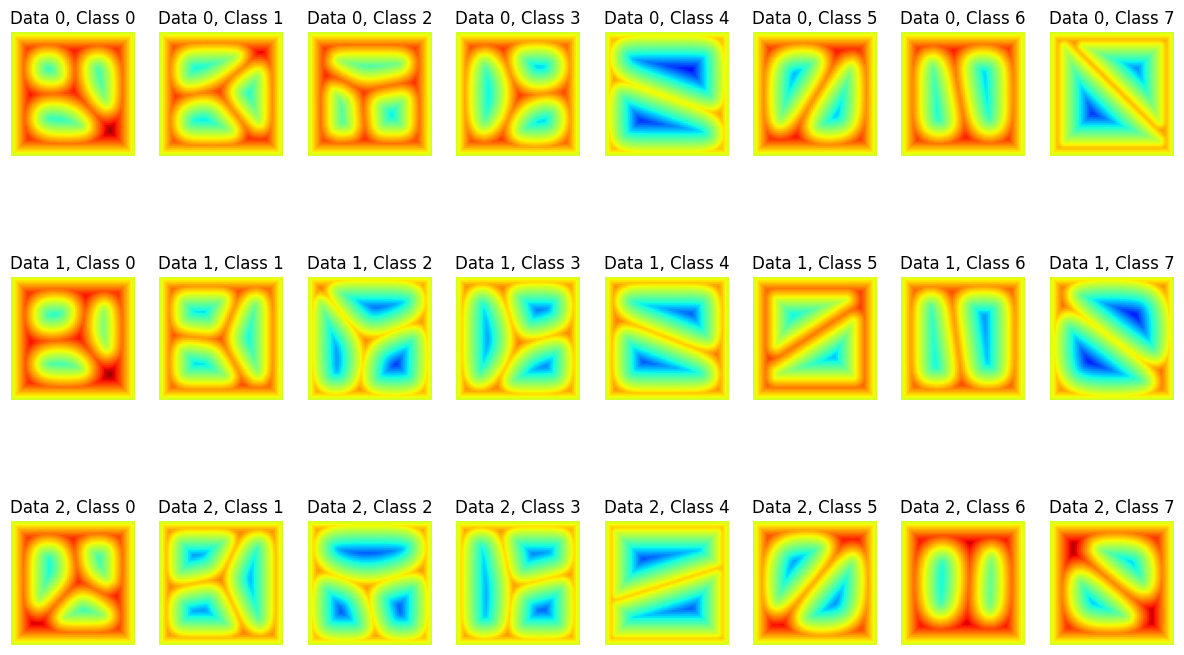

In [19]:
data, labels = dataLoader("data/sdf_images.mat")

fig, ax = plt.subplots(3,8)
fig.set_size_inches(15,9)
for i in range(8):
    idxs = np.where(labels == i)[0][:3]
    plot_sdf(data[idxs[0],:], ax[0][i], f"Data 0, Class {i}")
    plot_sdf(data[idxs[1],:], ax[1][i], f"Data 1, Class {i}")
    plot_sdf(data[idxs[2],:], ax[2][i], f"Data 2, Class {i}")


## Explained Variance

Use `train_test_split()` to partition the data and labels into a training and test set with `test_size = 0.2` and `random_state = 0`. Then train a PCA model on the training data and generate a bar plot of the variance explained for the first 25 principal components. Determine the number of principal components required to explain > 90% of the variance in the training data.

(640, 4096)
(160, 4096)
(640,)
(160,)


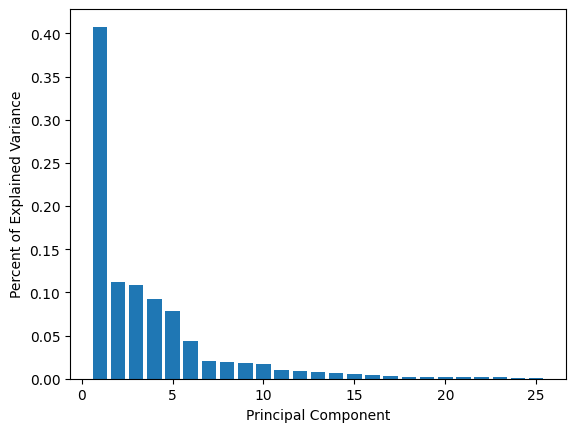

8 Components are needed to explain > 90% of the variance.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

pca = PCA(n_components=25)
pca.fit(X_train)
A = pca.transform(X_train)
X_recon = pca.inverse_transform(A)

plt.figure()
plt.bar(1+np.arange(25),pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Percent of Explained Variance")
plt.show()

s = 0
for i,percentage in enumerate(pca.explained_variance_ratio_):
    s += percentage
    if s > 0.9:
        print(f"{i} Components are needed to explain > 90% of the variance.")
        break

## PCA Reconstruction

Using the training data, generate 4 PCA models using 3, 10, 50, and all of the principal components. Use these models to transform the test data into the reduced space, and then reconstruct the data from the reduced space. Plot the reconstruction for each model, on the first occurence of each class in the test set. Your generated plot should be a 4x8 subplot figure, with each subplot title containing the class and the number of PCs used.

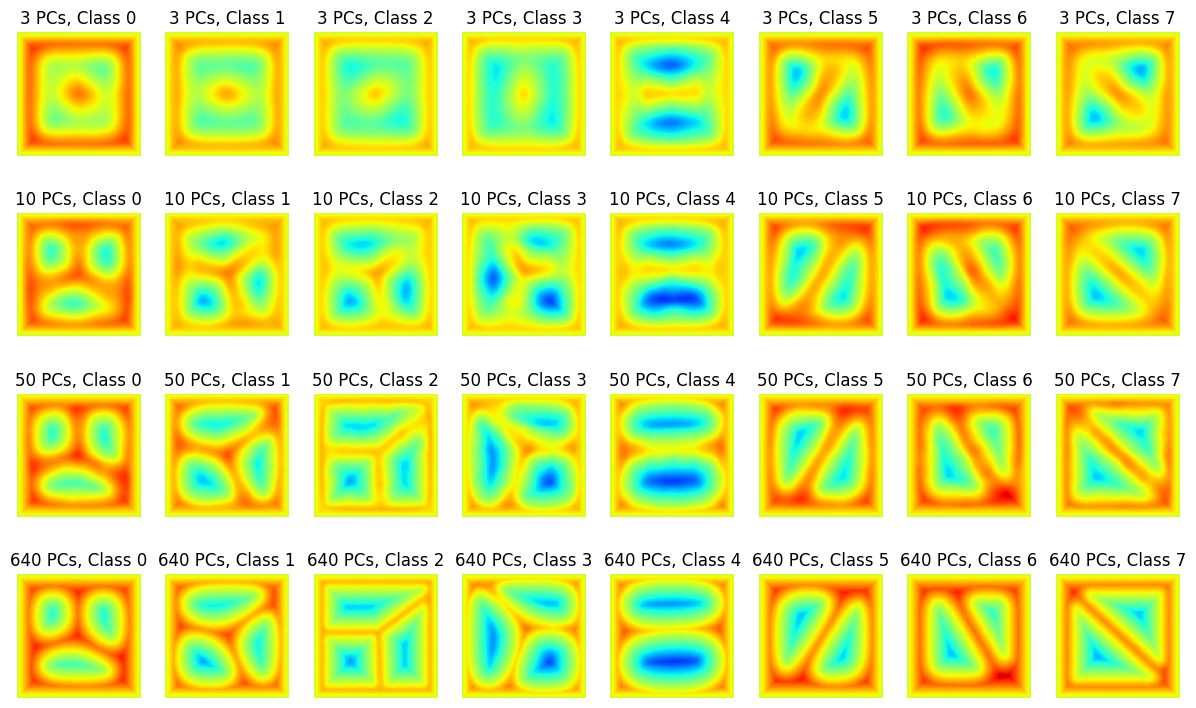

In [23]:
pcas = []
fig, ax = plt.subplots(4,8)
fig.set_size_inches(15,9)
for i,n_components in enumerate([3, 10, 50, len(X_train[:,0])]):
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    A = pca.transform(X_test)
    X_recon = pca.inverse_transform(A)
    for j in range(8):
        idxs = np.where(y_test == j)[0]
        plot_sdf(X_recon[idxs[0],:], ax[i][j], f"{n_components} PCs, Class {j}")
    
    pcas.append(pca)

## KNN on PCA Reduced Data

Now train a KNN classifier to predict the class of the 3D, 10D, and 50D PCA reduced data. You should train the KNN on the reduced training data, and report the prediction accuracy on the test set. You will also need to determine the `n_neighbors` parameter for your KNN classifier that gives good results.

In [38]:
for pca,name in zip(pcas[:-1],["3D", "10D", "50D"]):
    A_train = pca.transform(X_train)
    knn = KNeighborsClassifier(n_neighbors=15).fit(A_train, y_train)
    A_test = pca.transform(X_test)
    y_pred = knn.predict(A_test)
    acc = np.sum(y_pred == y_test)/len(y_test) * 100
    print(f"{name} PCA Classifier KNN Test Accuracy: {acc}%")

3D PCA Classifier KNN Test Accuracy: 70.625%
10D PCA Classifier KNN Test Accuracy: 90.0%
50D PCA Classifier KNN Test Accuracy: 93.125%


## TSNE Visualization
First reduced the full dataset to 50D using PCA, and then further reduced the data to 2D using TSNE. Plot the 2D reduced feature space with a scatter plot, coloring each point according to its class.

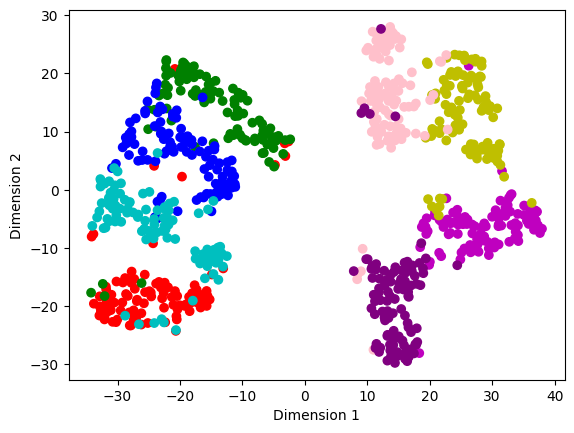

In [42]:
A_50D = pcas[2].transform(data)
A_2D = TSNE(2,perplexity=30,random_state=123).fit_transform(A_50D)

c = ['r', 'g', 'b', 'c', 'm', 'y', 'pink', 'purple']
colors = [c[i] for i in labels]
plt.figure()
plt.scatter(A_2D[:,0], A_2D[:,1],color=colors)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## KNN on PCA/TSNE Reduced Data

Using the same 2D PCA/TSNE data, split the data into train and test data and labels using `train_test_split` with a `random_state = 0` parameter so you have the same train/test partition as before. Then, train a KNN on this 2D feature space with the training set, and report the KNN classifier accuracy on the test set. Again, you will need to determine the `n_neighbors` parameter in the KNN classifier that gives good results.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(A_2D, labels, test_size=0.2, random_state=0)

knn = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = np.sum(y_pred == y_test)/len(y_test) * 100
print(f"Reduced PCA/TSNE KNN Classifier Test Accuracy: {acc}%")

Reduced PCA/TSNE KNN Classifier Test Accuracy: 91.875%


## Discussion

1. Discuss how the number of principal components relates to the quality of reconstruction of the data. Using all of the principal components, should there be any error in the reconstruction of a sample from the training data? What about in the reconstruction of an unseen sample from the testing data?

2. Discuss how you determined `k`, the number of neighbors in your KNN models. Why do we perform dimensionality reduction to our data before feeding it to our KNN classifier?

*Your response goes here*

1. As the number of principle components increases, the final reconstructed image approaches the original image. This continues until the number of principle components reaches the maximum at which the reconstructed image should match exactly to the original image. For data in the test set, the reconstructed image should match fairly closely to the original image with the maximum principal components but shouldn't match perfectly.

2. K was adjusted until the test accuracy of the models was maximized across all trained models. So for the 3 trained together, the number of neighbors was tuned to have good performance across all 3 models.